In [1]:
# importing other ppl's code
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

# importing my own code
from lib.diffeq import crank_nicolson_solve

# Theory

We have been told to solve the diffusion equation for the magnetic field in cylindrical coordinates. The equation is given by

$$\frac{\partial \mathbf{B}}{\partial t} = \nabla \times (\mathbf{V} \times \mathbf{B}) + \eta_T \nabla^2 \mathbf{B} + ...$$

where $\mathbf{B}$ is the magnetic field, $\eta_T$ is the magnetic diffusivity, and $\mathbf{V}$ is the velocity field. The first term on the right-hand side is the diffusion term, and the second term is the advection term.

Now, we have been instructed to ignore the $\nabla \times (\mathbf{V} \times \mathbf{B})$ term, and the other terms. Thus the equation becomes:

$$\frac{\partial \mathbf{B}}{\partial t} = \eta_T \nabla^2 \mathbf{B}$$

Expanding the Laplacian in cylindrical coordinates, we get:

$$\frac{\partial \mathbf{B}}{\partial t} = \eta_T \left( \frac{\partial^2 \mathbf{B}}{\partial r^2} + \frac{1}{r} \frac{\partial \mathbf{B}}{\partial r} + \frac{\partial^2 \mathbf{B}}{\partial z^2} \right)$$

Now, I have been instructed to solve this equation assuming that the magnetic field is constant along the $r$ direction, and that it is a function of $z$ only. Thus for me, the differential equation to solve becomes:

$$\frac{\partial B}{\partial t} = \eta_T \frac{\partial^2 B}{\partial z^2}$$

This differential equation turns out to be an elliptic partial differential equation, and solving it is well explored in literature. We will use the crank-nicolson method (popularly used to solve heat equations) to solve this equation. The crank-nicolson method is a finite difference method, and it is **unconditionally stable**. Although that doesn't mean that it is accurate, it is a good starting point for solving partial differential equations.

# Defining some utility functions and some constants

In [2]:
# simulation parameters
L = 8     # total z axis length - in some units
T = 1     # time length - in some units
Nl = 500  # number of spatial steps
Nt = 500  # number of time steps

# spatial and time grids definition
x = np.linspace(0, L, Nl + 1)
time = np.linspace(0, T, Nt + 1)


def make_gif(x, u, name, skip_frame = 1, till=None, fps=25):
    """

    Args:
        u (_type_): _description_
        name (_type_): _description_
        skip_frame (int, optional): _description_. Defaults to 1.
        till (_type_, optional): _description_. Defaults to None.
        fps (int, optional): _description_. Defaults to 25.
    """
    u = u[:till:skip_frame] if till is not None else u[::skip_frame]
    max_B = np.max(u)

    p = tqdm(total=u.shape[0]+1)

    fig, ax = plt.subplots()
    def update(frame):
        p.update(1)
        ax.clear()
        # a thin gray half-transparent line
        ax.plot(x, u[0], "r--", label="Initial Condition", alpha=0.4)
        ax.plot(x, u[frame], label=f'Time Step {frame*skip_frame}')
        plt.ylim(0, max_B)
        ax.set_title('Magnetic Field Strength vs z Distance')
        ax.set_xlabel('Distance')
        ax.set_ylabel('B')
        ax.legend(loc='upper right')
        ax.grid()

    animation = FuncAnimation(fig, update, frames=u.shape[0], interval=int(1000/fps), repeat=False)
    animation.save(f"outputs/asgt1/{name}", writer='imagemagick')
    p.close()

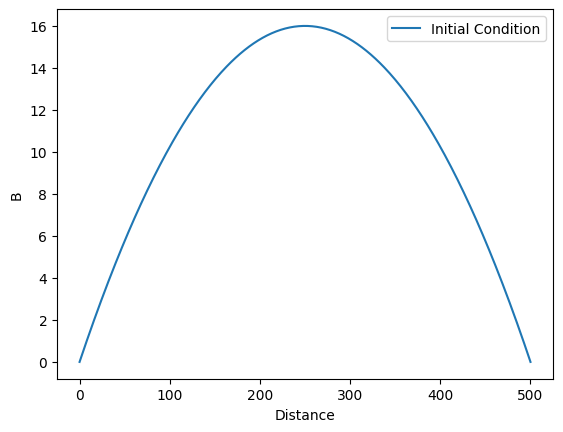

In [14]:
u0 = x*L - x**2  # one
plt.plot(u0, label="Initial Condition")
# plt.title('Magnetic Field Strength vs z Distance')
plt.xlabel('Distance')
plt.ylabel('B')
plt.legend(loc='upper right')

In [ ]:
u = crank_nicolson_solve(u0, L, T, Nl, Nt, eta=1)

In [ ]:
make_gif(u, "crank_nicolson.gif", skip_frame=1, till=200, fps=25)

![animation.gif](crank_nicolson.gif)

In [ ]:
u0 = x*L - x**2 + 2*np.cos(20*math.pi*x/L)  # two
plt.plot(u0)